In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

**Loading the dataset**

In [2]:
# Load dataset
df=pd.read_csv("modified_sleep_dataset.csv")

**Data Exploration-checking whether the dataset loaded correctly**

In [3]:
# Data Exploration
print("First 5 rows of dataset:")
print(df.head())

First 5 rows of dataset:
   Gender  Occupation BMI Category Sleep Disorder  Age  Sleep Duration  \
0    Male      Doctor       Normal    Sleep Apnea   50             7.0   
1  Female       Nurse       Normal            NaN   34             6.0   
2    Male  Accountant       Normal            NaN   56             6.0   
3  Female     Teacher       Normal            NaN   40             7.0   
4  Female  Accountant       Normal    Sleep Apnea   43             6.0   

   Quality of Sleep  Physical Activity Level  Stress Level  Heart Rate  \
0                 5                       30             7          65   
1                 7                       55             4          74   
2                 6                       62             6          78   
3                 8                       69             4          68   
4                 8                       61             4          72   

   Daily Steps  Systolic BP  Diastolic BP  
0         6207          129            80

**To know the datatypes,memory usage,non-null count**

In [4]:
print("\nDataset Information:")
print(df.info())


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Gender                   10000 non-null  object 
 1   Occupation               10000 non-null  object 
 2   BMI Category             10000 non-null  object 
 3   Sleep Disorder           4146 non-null   object 
 4   Age                      10000 non-null  int64  
 5   Sleep Duration           10000 non-null  float64
 6   Quality of Sleep         10000 non-null  int64  
 7   Physical Activity Level  10000 non-null  int64  
 8   Stress Level             10000 non-null  int64  
 9   Heart Rate               10000 non-null  int64  
 10  Daily Steps              10000 non-null  int64  
 11  Systolic BP              10000 non-null  int64  
 12  Diastolic BP             10000 non-null  int64  
dtypes: float64(1), int64(8), object(4)
memory usage: 1015.8

**Summary statistics are useful in normalization, feature selection, and outlier handling**

In [5]:
print("\nSummary Statistics:")
print(df.describe())


Summary Statistics:
                Age  Sleep Duration  Quality of Sleep  \
count  10000.000000    10000.000000      10000.000000   
mean      41.777300        6.705890          6.813900   
std        8.235538        0.732523          1.191893   
min       27.000000        5.800000          4.000000   
25%       36.000000        6.000000          6.000000   
50%       42.000000        7.000000          7.000000   
75%       48.000000        7.000000          8.000000   
max       59.000000        8.500000          9.000000   

       Physical Activity Level  Stress Level    Heart Rate   Daily Steps  \
count             10000.000000  10000.000000  10000.000000  10000.000000   
mean                 58.686700      4.967300     69.858300   6817.238400   
std                  17.889079      1.519823      3.669464   1565.075192   
min                  30.000000      3.000000     65.000000   3000.000000   
25%                  45.000000      4.000000     67.000000   5759.000000   
50%      

**Duplicates can bias your model, especially if they:Are exact repetitions of real-world entries,Overrepresent certain patterns or labels,It's a data cleaning step to improve model fairness and accuracy.**

In [6]:
# Checking for Duplicates
duplicate_rows = df.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicate_rows}")
df = df.drop_duplicates()


Number of duplicate rows: 0


**Identify data quality issues Decide how to handle missing values: Drop rows/columns, Fill using mean, median, mode, etc.Use ML-based imputation methods (KNN, regression)**



In [7]:
# Checking for Missing Values
missing_values = df.isnull().sum()
print("\nMissing Values:\n", missing_values)


Missing Values:
 Gender                        0
Occupation                    0
BMI Category                  0
Sleep Disorder             5854
Age                           0
Sleep Duration                0
Quality of Sleep              0
Physical Activity Level       0
Stress Level                  0
Heart Rate                    0
Daily Steps                   0
Systolic BP                   0
Diastolic BP                  0
dtype: int64


**The median is a robust measure of central tendency, less affected by outliers compared to the mean.Good choice when numeric features may have skewed distributions.Keeps dataset size unchanged**

In [8]:
# Handling Missing Values
df.fillna(df.median(numeric_only=True), inplace=True)

**select numeric columns-Extracts names of all numeric columns to analyze only those for outliers.Computes the Z-score (standard score) for each value in numeric columns.Z-score tells how many standard deviations a data point is from the mean.Taking abs() ensures both positive and negative outliers are captured.Points with Z-score > 3 (or < -3) are considered outliers.Keeps only rows where all numeric feature Z-scores are less than 3.Effectively removes any row with an outlier in any numeric column.**



In [9]:
# Outlier Detection & Handling using Z-score
numeric_cols = df.select_dtypes(include=[np.number]).columns
z_scores = np.abs(zscore(df[numeric_cols]))
threshold = 3
df = df[(z_scores < threshold).all(axis=1)]

**Sleep_Consistency
Creates a new feature measuring a kind of adjusted sleep duration by reducing it based on the Quality of Sleep.Intuition: Even if you sleep longer, lower sleep quality reduces “effective” sleep consistency.**
**2. Activity_Stress_Interaction
A ratio that balances physical activity with stress level, avoiding division by zero with +1 in denominator.
Intuition: This interaction captures how physical activity levels relate to stress — e.g., more activity might reduce stress or vice versa.**

In [10]:
# Feature Engineering
df["Sleep_Consistency"] = df["Sleep Duration"] - df["Quality of Sleep"] * 0.5
df["Activity_Stress_Interaction"] = df["Physical Activity Level"] / (df["Stress Level"] + 1)

**Creates histograms for all numeric columns in the DataFrame df.bins=30 divides the data range into 30 intervals (bins) to show frequency distribution.edgecolor='black' adds black borders to bars for better visual clarity.Sets overall figure size and adds a title.**

<Figure size 1200x600 with 0 Axes>

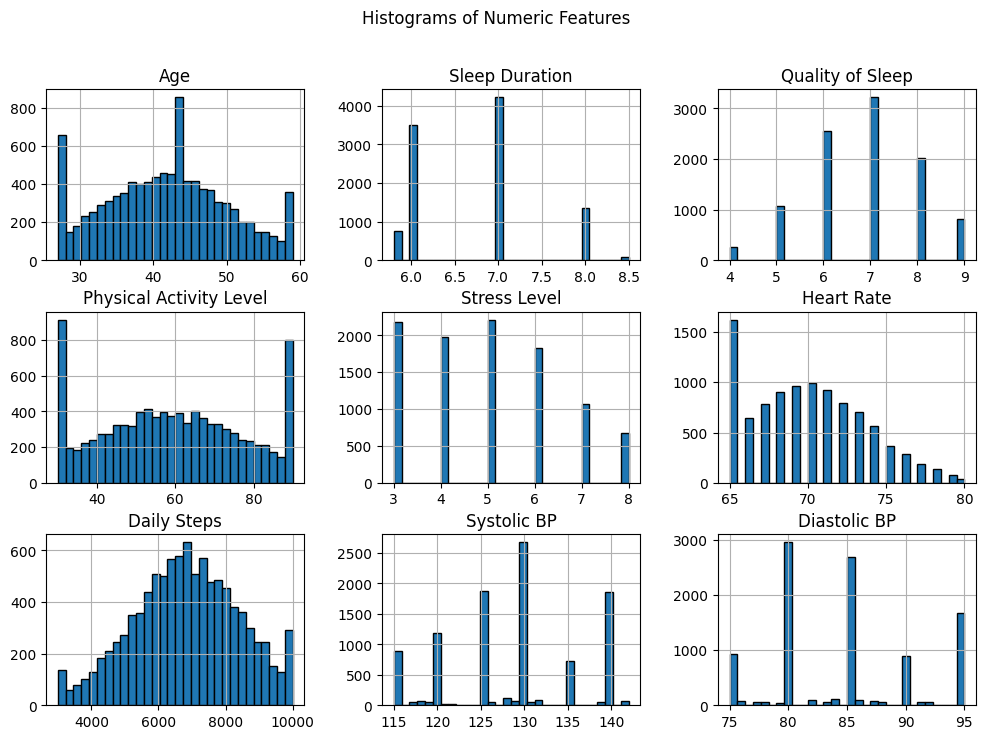

In [11]:
# Data Visualization
plt.figure(figsize=(12, 6))
df[numeric_cols].hist(bins=30, figsize=(12, 8), edgecolor='black')
plt.suptitle("Histograms of Numeric Features")
plt.show()

**Loops through each numeric column in the dataset.Uses Seaborn’s kdeplot to draw the Kernel Density Estimation plot — a smoothed version of the histogram.Displays all KDE curves on a single plot, with a legend for clarity.**

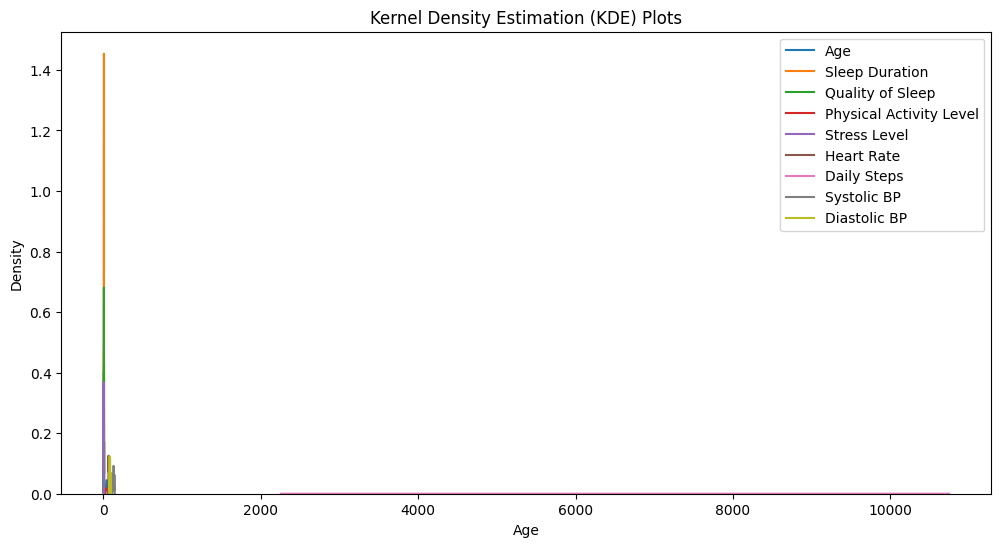

In [12]:
plt.figure(figsize=(12, 6))
for col in numeric_cols:
    sns.kdeplot(df[col], label=col)
plt.title("Kernel Density Estimation (KDE) Plots")
plt.legend()
plt.show()

**df[numeric_cols].corr(): Calculates Pearson correlation coefficients between all numeric features.
sns.heatmap(): Visualizes this correlation matrix as a color-coded grid.
annot=True: Displays the numeric correlation values inside each cell.
cmap="coolwarm": Uses a diverging color scheme (blue to red) for negative to positive correlations.
linewidths=0.5: Adds borders between cells.
fmt=".2f": Rounds displayed values to 2 decimal places.**

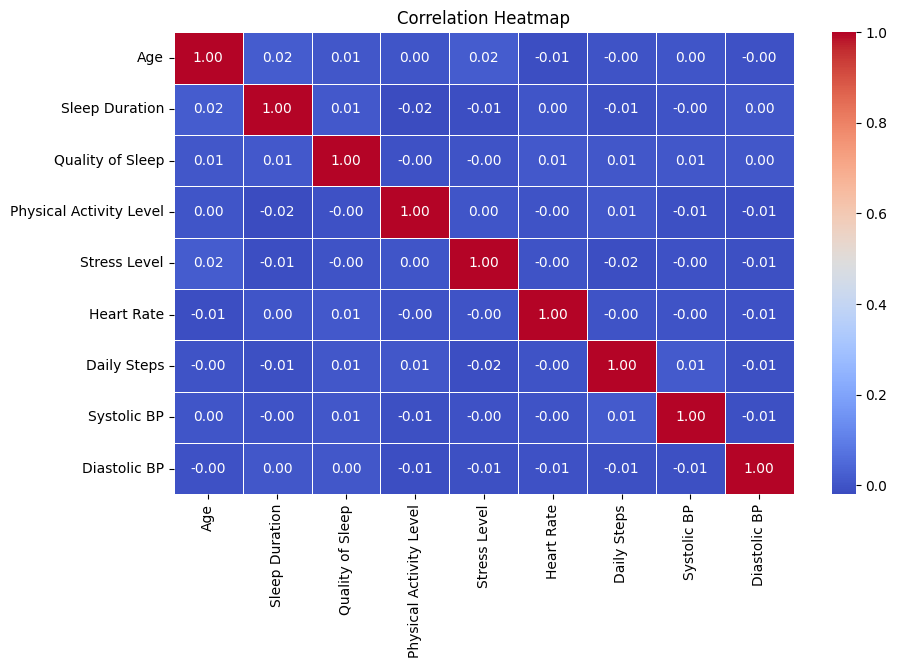

In [13]:
plt.figure(figsize=(10, 6))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

**Keeps training and testing data separate, preventing data leakage.
Ensures the model generalizes well to unseen data.
Incorporates engineered features which may improve model performance.**

In [14]:
# Model Selection and Hyperparameter Tuning
features = ["Age", "Sleep Duration", "Systolic BP","Diastolic BP","Physical Activity Level", "Stress Level", "Heart Rate", "Daily Steps", "Sleep_Consistency", "Activity_Stress_Interaction"]
target = "Quality of Sleep"

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Prevents underfitting or overfitting by optimizing hyperparameters.
Uses cross-validation to ensure model generalizes well.
Random Forests are robust, but tuning significantly boosts performance**

In [15]:
# Hyperparameter tuning for Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grids_search = GridSearchCV(RandomForestRegressor(), param_grid, cv=5, scoring='r2', n_jobs=-1)
grids_search.fit(X_train, y_train)

best_rf = grids_search.best_estimator_
print(f"Best parameters: {grids_search.best_params_}")

Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}


**MAE-Measures the average absolute difference between actual and predicted values.
MSE-Penalizes larger errors more heavily (squares the errors).
R² Measures how well the model explains the variance in the target.**



In [16]:
# Model Evaluation
y_pred = best_rf.predict(X_test)
print("\nRandom Forest Performance After Tuning:")
print(f"MAE: {mean_absolute_error(y_test, y_pred)}")
print(f"MSE: {mean_squared_error(y_test, y_pred)}")
print(f"R2 Score: {r2_score(y_test, y_pred)}")


Random Forest Performance After Tuning:
MAE: 0.0006183564886477998
MSE: 0.00041639175187875625
R2 Score: 0.9997231778707106


**Avoids misleading performance estimates that might result from a lucky or unlucky train/test split.
Helps detect overfitting — if training score is high but CV score is low.
More reliable than single-split evaluation, especially for smaller datasets.**

In [17]:
# Cross-Validation
cv_scores = cross_val_score(best_rf, X, y, cv=5, scoring='r2')
print(f"Cross-Validation R2 Scores: {cv_scores}")
print(f"Mean CV R2 Score: {np.mean(cv_scores)}")

Cross-Validation R2 Scores: [0.99997428 0.99998857 0.99994205 0.99970358 0.99972913]
Mean CV R2 Score: 0.9998675225768467


**Identifies key drivers of sleep quality.
Enables feature selection — less important features can potentially be removed to reduce complexity.
Supports domain understanding — e.g., discovering if "Stress Level" or "Sleep Duration" is a stronger predictor.**

In [18]:
# Feature Importance Analysis
feature_importances = best_rf.feature_importances_
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances}).sort_values(by='Importance', ascending=False)
print("\nFeature Importance:")
print(importance_df)


Feature Importance:
                       Feature    Importance
8            Sleep_Consistency  7.412799e-01
1               Sleep Duration  2.587162e-01
4      Physical Activity Level  3.565253e-06
6                   Heart Rate  2.689834e-07
0                          Age  0.000000e+00
2                  Systolic BP  0.000000e+00
3                 Diastolic BP  0.000000e+00
5                 Stress Level  0.000000e+00
7                  Daily Steps  0.000000e+00
9  Activity_Stress_Interaction  0.000000e+00


**Confirms the model performs well on truly unseen data
Helps ensure the model won't overfit when deployed
Validates the GridSearch + CV approach worked effectively**

In [19]:
# Testing on Completely Unseen Data (Simulated by holding out 10% of original dataset)
X_train_final, X_holdout, y_train_final, y_holdout = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
best_rf.fit(X_train_final, y_train_final)
y_holdout_pred = best_rf.predict(X_holdout)
print("\nPerformance on Completely Unseen Data:")
print(f"MAE: {mean_absolute_error(y_holdout, y_holdout_pred)}")
print(f"MSE: {mean_squared_error(y_holdout, y_holdout_pred)}")
print(f"R2 Score: {r2_score(y_holdout, y_holdout_pred)}")


Performance on Completely Unseen Data:
MAE: 0.0007228865146578681
MSE: 0.0001389888986442305
R2 Score: 0.9999001442407959


**Quickly see how well your model performs.
Detect patterns of bias (e.g., always predicting lower for high actual values).
Spot outliers or inconsistent behavior**

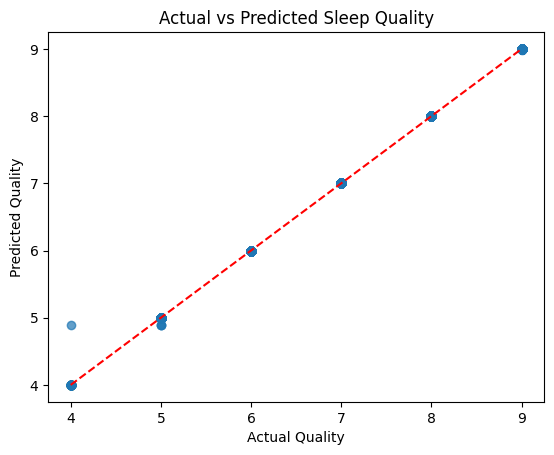

In [22]:
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel("Actual Quality")
plt.ylabel("Predicted Quality")
plt.title("Actual vs Predicted Sleep Quality")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.show()

**Reuse the trained model in production, deployment, or further analysis.
Avoids retraining time and computation.
Easy to share or move the model.**

In [20]:
import joblib
joblib.dump(best_rf, 'model.pkl')

['model.pkl']

**When you deploy or later use your saved model (model.pkl), you must prepare input data with the same features in the same order.
Saving this list ensures consistency between training and inference.
Helps avoid errors when transforming new input data for prediction**

In [21]:
import pickle

# List of features IN THE EXACT ORDER used for training
features = [
    'Age',
    'Sleep Duration', 
    'Systolic BP',
    'Diastolic BP',
    'Physical Activity Level',
    'Stress Level',
    'Heart Rate',
    'Daily Steps',
    'Sleep_Consistency',           # Your engineered feature
    'Activity_Stress_Interaction'  # Your engineered feature
]

# Save the feature list
with open('model_features.pkl', 'wb') as f:
    pickle.dump(features, f)